In [2]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../src')

In [3]:
from data_processing import (
    CustomerAggregator,
    TimeFeatureExtractor,
    WoEEncoder,
    CategoricalEncoder,
    MissingValueHandler,
    process_data
)

In [4]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
df = pd.read_csv('../data/raw/data.csv')


In [7]:
print("Original Data Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

Original Data Shape: (95662, 16)

First few rows:
         TransactionId         BatchId       AccountId       SubscriptionId  \
0  TransactionId_76871   BatchId_36123  AccountId_3957   SubscriptionId_887   
1  TransactionId_73770   BatchId_15642  AccountId_4841  SubscriptionId_3829   
2  TransactionId_26203   BatchId_53941  AccountId_4229   SubscriptionId_222   
3    TransactionId_380  BatchId_102363   AccountId_648  SubscriptionId_2185   
4  TransactionId_28195   BatchId_38780  AccountId_4841  SubscriptionId_3829   

        CustomerId CurrencyCode  CountryCode    ProviderId     ProductId  \
0  CustomerId_4406          UGX          256  ProviderId_6  ProductId_10   
1  CustomerId_4406          UGX          256  ProviderId_4   ProductId_6   
2  CustomerId_4683          UGX          256  ProviderId_6   ProductId_1   
3   CustomerId_988          UGX          256  ProviderId_1  ProductId_21   
4   CustomerId_988          UGX          256  ProviderId_4   ProductId_6   

      ProductCateg

In [8]:
## Step 1: Create Aggregate Features at Customer Level

print("\n" + "="*80)
print("STEP 1: CREATING AGGREGATE FEATURES")
print("="*80)

aggregator = CustomerAggregator(
    customer_id_col='CustomerId',
    amount_col='Amount',
    date_col='TransactionStartTime'
)


STEP 1: CREATING AGGREGATE FEATURES



Customer-level features created:
        CustomerId  Recency  Total_Transaction_Amount  \
0     CustomerId_1       83                  -10000.0   
1    CustomerId_10       83                  -10000.0   
2  CustomerId_1001       89                   20000.0   
3  CustomerId_1002       25                    4225.0   
4  CustomerId_1003       11                   20000.0   

   Average_Transaction_Amount  Median_Transaction_Amount  \
0               -10000.000000                   -10000.0   
1               -10000.000000                   -10000.0   
2                 4000.000000                     5200.0   
3                  384.090909                      -25.0   
4                 3333.333333                     3000.0   

   Min_Transaction_Amount  Max_Transaction_Amount  Std_Transaction_Amount  \
0                -10000.0                -10000.0                     NaN   
1                -10000.0                -10000.0                     NaN   
2                 -5000.0      

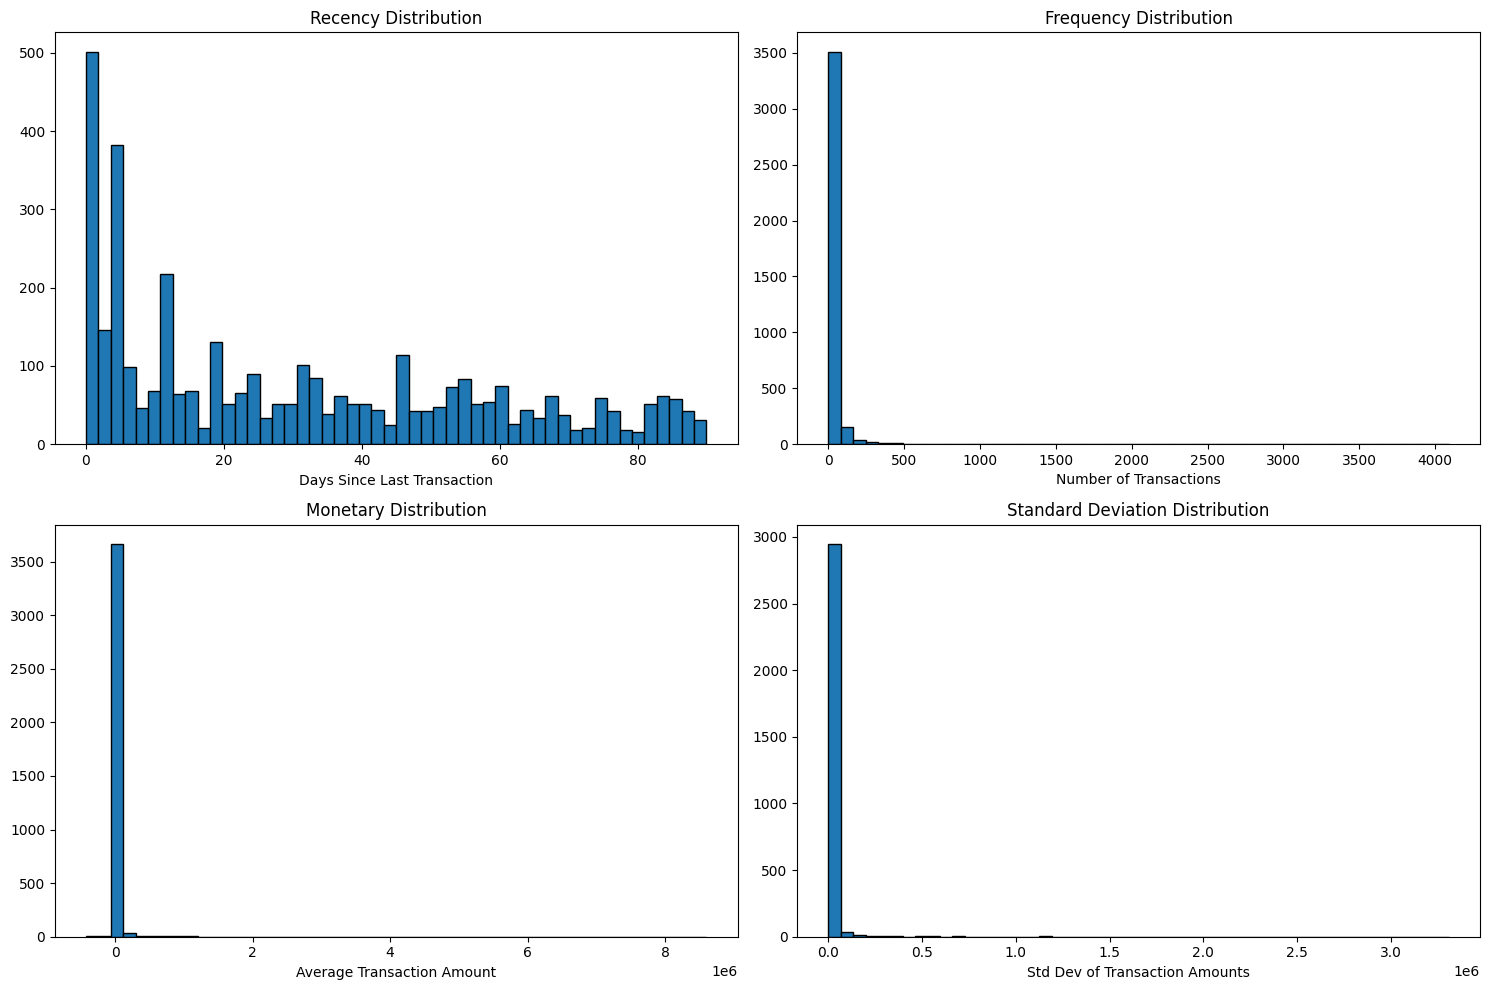

In [9]:
# Fit and transform
customer_features = aggregator.fit_transform(df)

print("\nCustomer-level features created:")
print(customer_features.head())
print(f"\nShape: {customer_features.shape}")
print("\nFeatures created:")
for col in customer_features.columns:
    print(f"  - {col}")

# Visualize RFMS distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].hist(customer_features['Recency'], bins=50, edgecolor='black')
axes[0, 0].set_title('Recency Distribution')
axes[0, 0].set_xlabel('Days Since Last Transaction')

axes[0, 1].hist(customer_features['Transaction_Count'], bins=50, edgecolor='black')
axes[0, 1].set_title('Frequency Distribution')
axes[0, 1].set_xlabel('Number of Transactions')

axes[1, 0].hist(customer_features['Average_Transaction_Amount'], bins=50, edgecolor='black')
axes[1, 0].set_title('Monetary Distribution')
axes[1, 0].set_xlabel('Average Transaction Amount')

axes[1, 1].hist(customer_features['Std_Transaction_Amount'], bins=50, edgecolor='black')
axes[1, 1].set_title('Standard Deviation Distribution')
axes[1, 1].set_xlabel('Std Dev of Transaction Amounts')

plt.tight_layout()
plt.show()

In [10]:
## Step 2: Extract Time-Based Features

print("\n" + "="*80)
print("STEP 2: EXTRACTING TIME-BASED FEATURES")
print("="*80)

time_extractor = TimeFeatureExtractor(date_col='TransactionStartTime')
df_with_time = time_extractor.fit_transform(df)

print("\nTime features extracted:")
time_features = [col for col in df_with_time.columns if 'Transaction_' in col]
for col in time_features:
    print(f"  - {col}")

# Aggregate time features to customer level
customer_time_features = df_with_time.groupby('CustomerId').agg({
    'Transaction_Hour': ['mean', 'std', 'min', 'max'],
    'Transaction_DayOfWeek': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 0,
    'Is_Weekend': 'mean',
    'Transaction_Month': 'nunique'
}).reset_index()

customer_time_features.columns = [
    'CustomerId', 
    'Avg_Transaction_Hour', 
    'Std_Transaction_Hour',
    'Min_Transaction_Hour',
    'Max_Transaction_Hour',
    'Most_Common_DayOfWeek',
    'Weekend_Transaction_Ratio',
    'Unique_Months_Active'
]

print("\nCustomer-level time features:")
print(customer_time_features.head())



STEP 2: EXTRACTING TIME-BASED FEATURES

Time features extracted:
  - Transaction_Hour
  - Transaction_Day
  - Transaction_Month
  - Transaction_Year
  - Transaction_DayOfWeek
  - Transaction_Quarter
  - Transaction_WeekOfYear

Customer-level time features:
        CustomerId  Avg_Transaction_Hour  Std_Transaction_Hour  \
0     CustomerId_1             16.000000                   NaN   
1    CustomerId_10             16.000000                   NaN   
2  CustomerId_1001              7.800000              0.447214   
3  CustomerId_1002             13.454545              5.428879   
4  CustomerId_1003             14.333333              0.516398   

   Min_Transaction_Hour  Max_Transaction_Hour  Most_Common_DayOfWeek  \
0                    16                    16                      2   
1                    16                    16                      2   
2                     7                     8                      4   
3                     4                    19            

In [11]:
# Merge with main customer features
customer_features = customer_features.merge(
    customer_time_features, 
    on='CustomerId', 
    how='left'
)

print(f"\nUpdated shape: {customer_features.shape}")

## Step 3: Create Default Proxy Variable (Target)

print("\n" + "="*80)
print("STEP 3: CREATING DEFAULT PROXY VARIABLE")
print("="*80)


Updated shape: (3742, 23)

STEP 3: CREATING DEFAULT PROXY VARIABLE



Default proxy created:
Good_Bad_Label
0    1934
1    1808
Name: count, dtype: int64

Good customers: 1808
Bad customers: 1934
Default rate: 51.68%


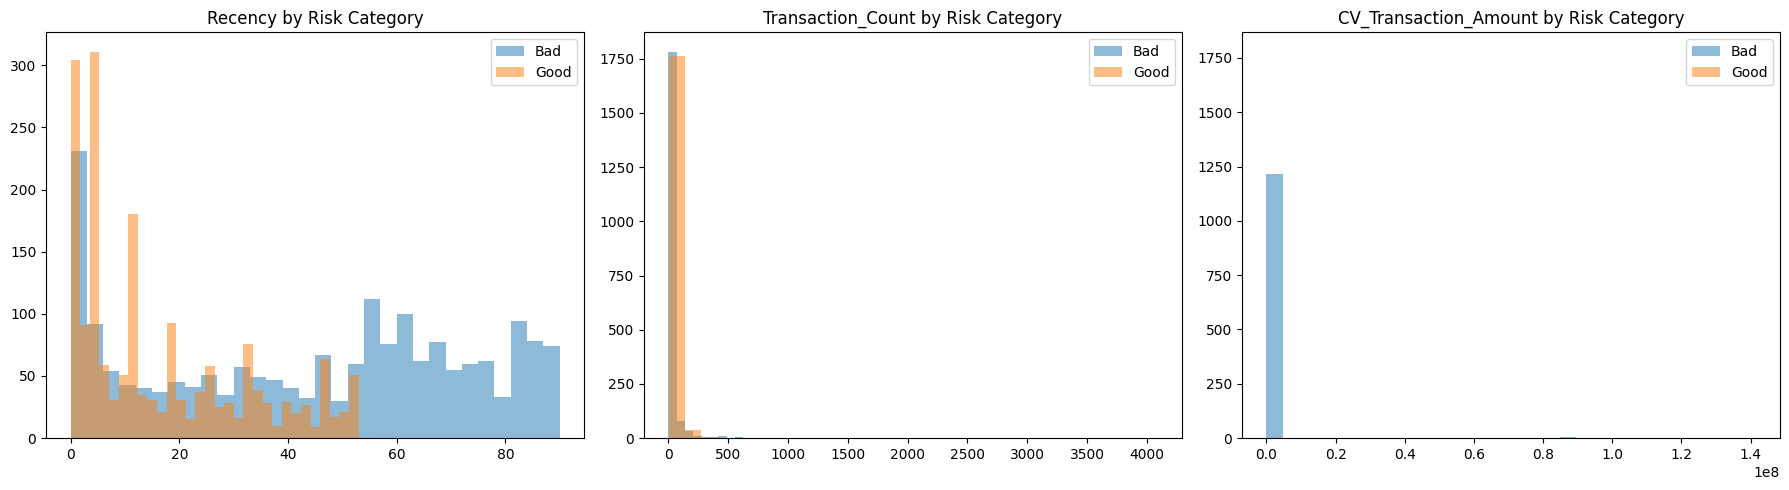

In [12]:
def create_default_proxy(df):
    """
    Create binary default proxy variable based on risk indicators.
    1 = Good customer (low risk)
    0 = Bad customer (high risk)
    """
    df = df.copy()
    
    # Calculate percentiles
    recency_75 = df['Recency'].quantile(0.75)
    frequency_25 = df['Transaction_Count'].quantile(0.25)
    cv_75 = df['CV_Transaction_Amount'].quantile(0.75)
    
    # High risk if:
    # - Recency > 75th percentile (dormant)
    # - Frequency < 25th percentile (infrequent)
    # - CV > 75th percentile (unstable)
    
    high_risk = (
        (df['Recency'] > recency_75) |
        (df['Transaction_Count'] < frequency_25) |
        (df['CV_Transaction_Amount'] > cv_75)
    )
    
    # Good = 1, Bad = 0
    df['Good_Bad_Label'] = (~high_risk).astype(int)
    
    return df

customer_features = create_default_proxy(customer_features)

print("\nDefault proxy created:")
print(customer_features['Good_Bad_Label'].value_counts())
print(f"\nGood customers: {customer_features['Good_Bad_Label'].sum()}")
print(f"Bad customers: {(customer_features['Good_Bad_Label'] == 0).sum()}")
print(f"Default rate: {(customer_features['Good_Bad_Label'] == 0).mean():.2%}")

# Visualize good vs bad customers
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, feature in enumerate(['Recency', 'Transaction_Count', 'CV_Transaction_Amount']):
    for label in [0, 1]:
        data = customer_features[customer_features['Good_Bad_Label'] == label][feature]
        axes[idx].hist(data, bins=30, alpha=0.5, 
                      label=f"{'Good' if label == 1 else 'Bad'}")
    axes[idx].set_title(f'{feature} by Risk Category')
    axes[idx].legend()

plt.tight_layout()
plt.show()


STEP 4: WOE ENCODING AND INFORMATION VALUE

Information Value Summary:
                   Feature       IV Predictive_Power
     CV_Transaction_Amount 6.519271      Very Strong
                   Recency 3.583626      Very Strong
    Std_Transaction_Amount 3.259623      Very Strong
         Transaction_Count 0.802038      Very Strong
Average_Transaction_Amount 0.264081           Medium
     Most_Common_DayOfWeek 0.145865           Medium
      Avg_Transaction_Hour 0.103060           Medium
 Weekend_Transaction_Ratio 0.062390             Weak


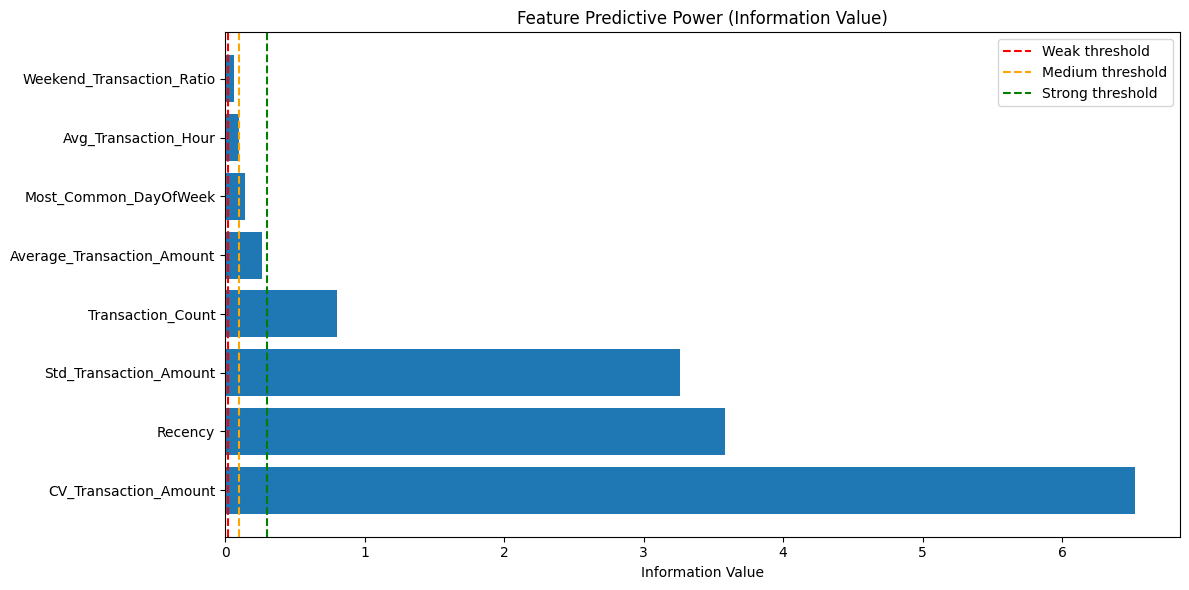


--------------------------------------------------------------------------------
IV Interpretation:
  < 0.02: Not Predictive
  0.02 - 0.10: Weak
  0.10 - 0.30: Medium
  0.30 - 0.50: Strong
  > 0.50: Very Strong (check for overfitting)
--------------------------------------------------------------------------------


In [13]:
## Step 4: Weight of Evidence (WoE) and Information Value (IV)

print("\n" + "="*80)
print("STEP 4: WOE ENCODING AND INFORMATION VALUE")
print("="*80)

# Define features for WoE encoding
categorical_features = ['Most_Common_DayOfWeek']
numerical_features = [
    'Recency', 
    'Transaction_Count',
    'Average_Transaction_Amount',
    'Std_Transaction_Amount',
    'CV_Transaction_Amount',
    'Avg_Transaction_Hour',
    'Weekend_Transaction_Ratio'
]

# Filter to existing columns
categorical_features = [c for c in categorical_features if c in customer_features.columns]
numerical_features = [c for c in numerical_features if c in customer_features.columns]

# Initialize WoE encoder
woe_encoder = WoEEncoder(
    categorical_cols=categorical_features,
    numerical_cols=numerical_features,
    n_bins=5
)

# Fit WoE encoder
X = customer_features.drop(['Good_Bad_Label'], axis=1)
y = customer_features['Good_Bad_Label']

woe_encoder.fit(X, y)

# Transform features
customer_features_woe = woe_encoder.transform(customer_features)

# Get IV summary
iv_summary = woe_encoder.get_iv_summary()

print("\nInformation Value Summary:")
print(iv_summary.to_string(index=False))

# Visualize IV
plt.figure(figsize=(12, 6))
plt.barh(iv_summary['Feature'], iv_summary['IV'])
plt.xlabel('Information Value')
plt.title('Feature Predictive Power (Information Value)')
plt.axvline(x=0.02, color='r', linestyle='--', label='Weak threshold')
plt.axvline(x=0.1, color='orange', linestyle='--', label='Medium threshold')
plt.axvline(x=0.3, color='g', linestyle='--', label='Strong threshold')
plt.legend()
plt.tight_layout()
plt.show()

print("\n" + "-"*80)
print("IV Interpretation:")
print("  < 0.02: Not Predictive")
print("  0.02 - 0.10: Weak")
print("  0.10 - 0.30: Medium")
print("  0.30 - 0.50: Strong")
print("  > 0.50: Very Strong (check for overfitting)")
print("-"*80)

In [14]:
## Step 5: Handle Missing Values

print("\n" + "="*80)
print("STEP 5: HANDLING MISSING VALUES")
print("="*80)

# Check for missing values
missing_summary = pd.DataFrame({
    'Column': customer_features_woe.columns,
    'Missing_Count': customer_features_woe.isnull().sum(),
    'Missing_Percentage': (customer_features_woe.isnull().sum() / len(customer_features_woe) * 100).round(2)
})
missing_summary = missing_summary[missing_summary['Missing_Count'] > 0]

if len(missing_summary) > 0:
    print("\nMissing values detected:")
    print(missing_summary.to_string(index=False))
    
    # Handle missing values
    missing_handler = MissingValueHandler(strategy='median')
    customer_features_clean = missing_handler.fit_transform(customer_features_woe)
    
    print("\nMissing values imputed using median strategy")
else:
    print("\n✓ No missing values detected!")
    customer_features_clean = customer_features_woe.copy()

## Step 6: Encode Categorical Variables

print("\n" + "="*80)
print("STEP 6: ENCODING CATEGORICAL VARIABLES")
print("="*80)

# Check for remaining categorical variables
categorical_cols = customer_features_clean.select_dtypes(
    include=['object', 'category']
).columns.tolist()

print(f"\nCategorical columns to encode: {categorical_cols}")

if len(categorical_cols) > 0:
    cat_encoder = CategoricalEncoder(strategy='label', top_n=10)
    customer_features_encoded = cat_encoder.fit_transform(customer_features_clean)
    print(f"Encoded {len(categorical_cols)} categorical variables")
else:
    print("No categorical variables to encode")
    customer_features_encoded = customer_features_clean.copy()


STEP 5: HANDLING MISSING VALUES

Missing values detected:
                Column  Missing_Count  Missing_Percentage
Std_Transaction_Amount            712               19.03
 CV_Transaction_Amount            712               19.03
  Std_Transaction_Hour            712               19.03

Missing values imputed using median strategy

STEP 6: ENCODING CATEGORICAL VARIABLES

Categorical columns to encode: ['CustomerId']
Encoded 1 categorical variables


In [15]:
## Step 7: Normalize/Standardize Numerical Features

print("\n" + "="*80)
print("STEP 7: NORMALIZING/STANDARDIZING FEATURES")
print("="*80)

from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Separate features and target
X = customer_features_encoded.drop(['CustomerId', 'Good_Bad_Label'], axis=1, errors='ignore')
y = customer_features_encoded['Good_Bad_Label'] if 'Good_Bad_Label' in customer_features_encoded.columns else None

print(f"\nFeatures to scale: {X.shape[1]} columns")

# Option 1: Standardization (mean=0, std=1)
print("\n[Option 1] Standardization (StandardScaler):")
scaler_standard = StandardScaler()
X_standardized = scaler_standard.fit_transform(X)
X_standardized = pd.DataFrame(X_standardized, columns=X.columns, index=X.index)

print(f"  Mean: {X_standardized.mean().mean():.4f}")
print(f"  Std: {X_standardized.std().mean():.4f}")

# Option 2: Normalization (range 0-1)
print("\n[Option 2] Normalization (MinMaxScaler):")
scaler_minmax = MinMaxScaler()
X_normalized = scaler_minmax.fit_transform(X)
X_normalized = pd.DataFrame(X_normalized, columns=X.columns, index=X.index)

print(f"  Min: {X_normalized.min().min():.4f}")
print(f"  Max: {X_normalized.max().max():.4f}")

# Use standardized version for modeling
X_final = X_standardized.copy()

# Add back customer ID and target
X_final['CustomerId'] = customer_features_encoded['CustomerId']
if y is not None:
    X_final['Good_Bad_Label'] = y

print(f"\nFinal processed dataset shape: {X_final.shape}")



STEP 7: NORMALIZING/STANDARDIZING FEATURES

Features to scale: 30 columns

[Option 1] Standardization (StandardScaler):
  Mean: 0.0000
  Std: 1.0001

[Option 2] Normalization (MinMaxScaler):
  Min: 0.0000
  Max: 1.0000

Final processed dataset shape: (3742, 32)


In [16]:
## Step 8: Save Processed Data

print("\n" + "="*80)
print("STEP 8: SAVING PROCESSED DATA")
print("="*80)

# Save processed data
output_path = '../data/processed/customer_features_processed.csv'
X_final.to_csv(output_path, index=False)
print(f"\n✓ Processed data saved to: {output_path}")

# Save feature names
feature_names = [col for col in X_final.columns if col not in ['CustomerId', 'Good_Bad_Label']]
feature_info = pd.DataFrame({
    'Feature': feature_names,
    'Type': [X_final[col].dtype for col in feature_names]
})
feature_info.to_csv('../data/processed/feature_names.csv', index=False)
print(f"✓ Feature info saved to: ../data/processed/feature_names.csv")

# Save IV summary if available
if 'iv_summary' in locals():
    iv_summary.to_csv('../data/processed/iv_summary.csv', index=False)
    print(f"✓ IV summary saved to: ../data/processed/iv_summary.csv")



STEP 8: SAVING PROCESSED DATA

✓ Processed data saved to: ../data/processed/customer_features_processed.csv
✓ Feature info saved to: ../data/processed/feature_names.csv
✓ IV summary saved to: ../data/processed/iv_summary.csv
